# **Getting the features**

In [1]:
%env CUDA_VISIBLE_DEVICES=0
!rm -rf .cache *.bz2 utils.py*
#!wget --quiet -c https://github.com/jubenjum/mcr_exp/raw/master/spectral_all_calls_variable_window.hdf5.bz2
#!wget --quiet -c https://github.com/jubenjum/mcr_exp/raw/master/SPECTRAL_STACK50_NFILT40_c11783_features.csv.bz2
!wget --quiet -c https://github.com/jubenjum/mcr_exp/raw/master/SPECTRAL_STACKFREE_NFILT40_c74e01_features.csv.bz2 ||  echo "SPECTRAL_STACKFREE_NFILT40_c74e01_features.csv.bz2 not found"
!wget --quiet -c https://github.com/jubenjum/mcr_exp/raw/master/utils.py || echo "utils.py not found"

!bunzip2 -f *.bz2
  

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from google.colab import files

from utils import *

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib inline


Using TensorFlow backend.


# **Loading/preparing features and calls**

In [3]:
# some common values
n_filters = 40

n_dimensions = 20

species = ['BM-Kenya', 'BM-Uganda', 'PN', 'TT', 'CB', 'CL']

to_remove = ['x', 'A', 'A*', 'Nscrm', 'BO', 'BS', 'Bw', 'C', 'K+/W+']

call2species = {'1':'PN', '2':'PN', '3':'PN', '4':'PN', 
                'A':'BM-Kenya', 'A*':'BM-Kenya', 'KA':'BM-Kenya', 'KATR':'BM-Kenya', 'Nscrm':'BM-Kenya', 'PY':'BM-Kenya', 'BO':'BM-Kenya',
                'h':'BM-Uganda', 'p':'BM-Uganda',
                'A_titi':'TT', 'B':'TT', 'BS':'TT', 'Bw':'TT',  'C':'TT', 'H':'TT', 'x':'TT',  
                'H':'CB', 'K':'CB', 'K+':'CB', 'W':'CB', 'W+':'CB', 'K+/W+':'CB',                 
                'r':'CL', 's':'CL'}


#with h5py.File("spectral_all_calls_variable_window.hdf5", "r") as f:
#    labels = np.array(f['labels'][:])
#    features = f['features'][:]


# reading features and labels, in the csv file the first column are the calls/labels 
# the rest are features
features_, labels_ = read_csv('SPECTRAL_STACKFREE_NFILT40_c74e01_features.csv')            
labels = pd.DataFrame(labels_).values.reshape(-1)
features = pd.DataFrame(features_).values
features = normalize(features)

samples, size_features =  features.shape
timesteps, input_dim = size_features/n_filters, n_filters

# reshaping the features for LSTM model
features = features.reshape(samples, timesteps, input_dim)

# only to have the names similar to other people's code
x = features.astype(np.float32)
y = LabelEncoder().fit(labels).transform(labels)

# shuffling features and labels to have mixed species
indices = np.arange(len(x))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]
shuffled_labels = labels[indices]

# if you do train/test splits
train_x, val_x, train_y, val_y = train_test_split(x, y, train_size=0.8, stratify=y)


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# **Training LSTM-autoencoder**

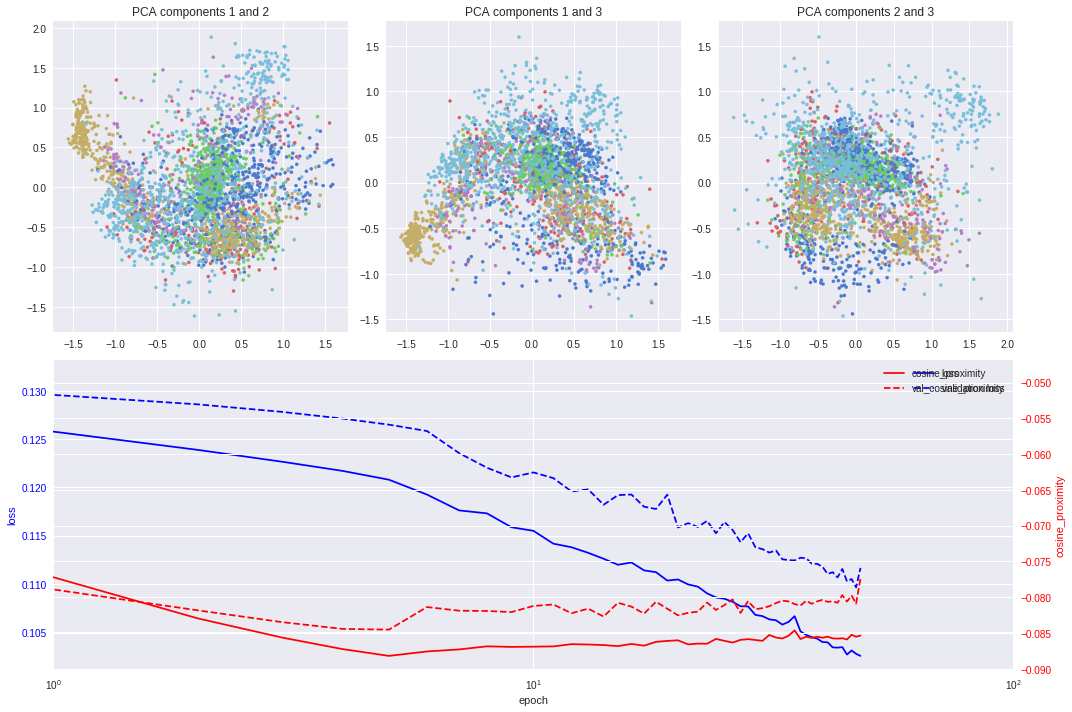

In [0]:
def get_model(n_dimensions):
    inputs = Input(shape=(timesteps, input_dim))
    mask = Masking(mask_value=0.0, name='mask')(inputs)
    encoded = LSTM(n_dimensions, return_sequences=False, name="encoder")(mask)
    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(input_dim, return_sequences=True, name='decoder')(decoded)

    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    return autoencoder, encoder
    
autoencoder_base, encoder_base = get_model(n_dimensions)
autoencoder_base.compile(optimizer='rmsprop', loss='mse', 
                         metrics=['acc', 'cosine_proximity'])
encoder_layer = 2 

n_epochs = 100

plotter = Plotter(encoder_base, x, y, shuffled_labels, encoder_layer, n_epochs, 
                  'cosine_proximity','val_cosine_proximity', 
                  'base_lstm_autoencoder')

history = autoencoder_base.fit(train_x, train_x, shuffle=False, verbose=0, 
                               epochs=n_epochs,
                               validation_data=(val_x, val_x),
                               callbacks=[plotter])



# **Encoding and plotting the features**

In [6]:
encoded_ = encoder_base.predict(features)
lstm_encoded_base = to_pandas(encoded_, labels)
plot_labels(lstm_encoded_base, 'lstm_encoded')


NameError: ignored

# **ABX plots**

In [7]:
plot_abx(encoded_, labels)

NameError: ignored

# **Save & download new features**

In [8]:
encoded_features = np.append(labels.reshape(-1,1), encoded_, axis=1)
fname = "lstm_encoded_features_{:02d}D.csv".format(n_dimensions)
pd.DataFrame(encoded_features).to_csv(fname)
files.download(fname)

NameError: ignored